In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)

Using device:  cuda


### Khởi tạo hyperparameters

In [3]:
# Hyperparameters
batch_size = 256
img_size = 28 # original image size is 28x28
channels = 1 # grayscale image
latent_dim = 2
num_epochs = 500 # training epochs

transform = transforms.Compose([
 transforms.Resize((img_size, img_size)),
 transforms.ToTensor(),
])

dataset = datasets.MNIST(
    root="./data", # Data storage directory
    train=True,
    transform=transform,
    download=True,
)

100%|██████████| 9.91M/9.91M [00:11<00:00, 888kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 63.8kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.59MB/s]


### Chia tập train, val với tỉ lệ 8:2



In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training samples: 48000, Validation samples: 12000


In [5]:
batch_samples, batch_labels = next(iter(train_loader))
batch_samples.shape, batch_labels.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

### Mô hình VAE

In [6]:
class VAEModel(nn.Module):
    def __init__(self, channels, latent_dim):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)

        self.flatten_dim = 64*7*7
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_final = nn.Conv2d(16, channels, kernel_size=3, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [7]:
def loss_function(recon_x, x, mu, log_var, B=1000):
    # Flatten tensors for MSE calculation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # Calculate MSE (per element average)
    mse_out = F.mse_loss(recon_x_flat, x_flat, reduction='mean')

    # Scale by input dimensions
    reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]

    # Calculate KL divergence
    kl_loss =-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)

    # Compute final loss (adding B*recon_loss + kl_loss)
    total_loss = B * reconstruction_loss + torch.mean(kl_loss)
    return total_loss, reconstruction_loss, torch.mean(kl_loss)

In [8]:
# Create model, optimizer, etc.
model = VAEModel(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [9]:
import os
from datetime import datetime

# Create a log directory if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a log file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.txt")

# Open the log file
with open(log_file, "w") as f:
    f.write(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: VAE with latent_dim={latent_dim}\n")
    f.write(f"Batch size: {batch_size}, Image size: {img_size}x{img_size}\n")
    f.write(f"Total epochs: {num_epochs}\n\n")
    f.write("Epoch,Avg_Loss,Recon_Loss,KL_Loss\n")

# Training loop with logging
model.train()

for epoch in range(num_epochs):
    train_loss = 0.0
    epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        epoch_bar.set_postfix(loss=loss.item())

    # Calculate average loss
    avg_loss = train_loss / len(train_loader.dataset)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f} "
            f"Recon Loss: {recon_loss.item():.4f} KL Loss: {kl_loss.item():.4f}")

    # Save to log file
    with open(log_file, "a") as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{recon_loss.item():.6f},{kl_loss.item():.6f}\n")
# Log training completion
with open(log_file, "a") as f:
    f.write(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print(f"Training log saved to {log_file}")

Epoch 1/500 Loss per sample: 325.5770 Recon Loss: 47.8862 KL Loss: 14.0319


Epoch 2/500 Loss per sample: 179.5445 Recon Loss: 40.4608 KL Loss: 13.7901


Epoch 3/500 Loss per sample: 160.2696 Recon Loss: 41.6192 KL Loss: 12.7399


Epoch 4/500 Loss per sample: 152.8686 Recon Loss: 37.2798 KL Loss: 13.3173


Epoch 5/500 Loss per sample: 148.7292 Recon Loss: 35.8117 KL Loss: 13.9856


Epoch 6/500 Loss per sample: 145.3263 Recon Loss: 37.8202 KL Loss: 14.3673


Epoch 7/500 Loss per sample: 142.7166 Recon Loss: 35.8263 KL Loss: 13.3707


Epoch 8/500 Loss per sample: 140.5029 Recon Loss: 35.8252 KL Loss: 14.1953


Epoch 9/500 Loss per sample: 138.8715 Recon Loss: 34.3999 KL Loss: 14.1694


Epoch 10/500 Loss per sample: 137.5373 Recon Loss: 36.3228 KL Loss: 14.6275


Epoch 11/500 Loss per sample: 136.1139 Recon Loss: 34.5808 KL Loss: 15.1531


Epoch 12/500 Loss per sample: 135.0652 Recon Loss: 34.9511 KL Loss: 15.0170


Epoch 13/500 Loss per sample: 134.9210 Recon Loss: 35.6092 KL Loss: 14.3525


Epoch 14/500 Loss per sample: 133.1176 Recon Loss: 33.4499 KL Loss: 15.4303


Epoch 15/500 Loss per sample: 132.5592 Recon Loss: 32.9561 KL Loss: 14.9040


Epoch 16/500 Loss per sample: 131.9137 Recon Loss: 33.9766 KL Loss: 16.0086


Epoch 17/500 Loss per sample: 131.3568 Recon Loss: 32.5392 KL Loss: 15.2123


Epoch 18/500 Loss per sample: 130.8503 Recon Loss: 32.9279 KL Loss: 15.9716


Epoch 19/500 Loss per sample: 130.2105 Recon Loss: 31.8151 KL Loss: 15.9949


Epoch 20/500 Loss per sample: 129.5625 Recon Loss: 34.1732 KL Loss: 15.3767


Epoch 21/500 Loss per sample: 129.1063 Recon Loss: 33.1467 KL Loss: 15.4391


Epoch 22/500 Loss per sample: 128.9475 Recon Loss: 30.9834 KL Loss: 15.4307


Epoch 23/500 Loss per sample: 128.3821 Recon Loss: 33.2264 KL Loss: 15.0091


Epoch 24/500 Loss per sample: 127.9871 Recon Loss: 32.6996 KL Loss: 15.3636


Epoch 25/500 Loss per sample: 127.6636 Recon Loss: 32.4621 KL Loss: 15.9446


Epoch 26/500 Loss per sample: 127.5720 Recon Loss: 32.5872 KL Loss: 15.7937


Epoch 27/500 Loss per sample: 126.9037 Recon Loss: 34.0172 KL Loss: 14.5269


Epoch 28/500 Loss per sample: 126.9815 Recon Loss: 30.7833 KL Loss: 16.7281


Epoch 29/500 Loss per sample: 126.5611 Recon Loss: 32.7924 KL Loss: 15.9694


Epoch 30/500 Loss per sample: 126.1812 Recon Loss: 32.0188 KL Loss: 15.4492


Epoch 31/500 Loss per sample: 125.7983 Recon Loss: 33.2107 KL Loss: 15.4215


Epoch 32/500 Loss per sample: 125.6388 Recon Loss: 29.7718 KL Loss: 15.8527


Epoch 33/500 Loss per sample: 125.3406 Recon Loss: 31.1829 KL Loss: 16.5992


Epoch 34/500 Loss per sample: 125.2448 Recon Loss: 33.5770 KL Loss: 15.2380


Epoch 35/500 Loss per sample: 124.8511 Recon Loss: 30.5788 KL Loss: 16.4813


Epoch 36/500 Loss per sample: 124.7751 Recon Loss: 34.3994 KL Loss: 15.1806


Epoch 37/500 Loss per sample: 124.4661 Recon Loss: 31.3068 KL Loss: 16.3277


Epoch 38/500 Loss per sample: 124.3375 Recon Loss: 30.7469 KL Loss: 16.1369


Epoch 39/500 Loss per sample: 124.1831 Recon Loss: 31.5952 KL Loss: 17.2208


Epoch 40/500 Loss per sample: 124.1101 Recon Loss: 32.2007 KL Loss: 17.0276


Epoch 41/500 Loss per sample: 123.7616 Recon Loss: 34.1584 KL Loss: 14.8943


Epoch 42/500 Loss per sample: 123.6275 Recon Loss: 32.6531 KL Loss: 17.0232


Epoch 43/500 Loss per sample: 123.5078 Recon Loss: 28.4995 KL Loss: 17.0349


Epoch 44/500 Loss per sample: 123.4511 Recon Loss: 31.8444 KL Loss: 16.4021


Epoch 45/500 Loss per sample: 123.1623 Recon Loss: 32.6818 KL Loss: 17.5949


Epoch 46/500 Loss per sample: 123.0474 Recon Loss: 31.4181 KL Loss: 16.8729


Epoch 47/500 Loss per sample: 122.7578 Recon Loss: 28.8492 KL Loss: 17.4537


Epoch 48/500 Loss per sample: 122.4995 Recon Loss: 31.0347 KL Loss: 16.8574


Epoch 49/500 Loss per sample: 122.6028 Recon Loss: 31.2076 KL Loss: 17.0826


Epoch 50/500 Loss per sample: 122.3939 Recon Loss: 29.1135 KL Loss: 17.4315


Epoch 51/500 Loss per sample: 122.3781 Recon Loss: 32.3669 KL Loss: 16.7040


Epoch 52/500 Loss per sample: 122.2697 Recon Loss: 30.4202 KL Loss: 16.6824


Epoch 53/500 Loss per sample: 121.8216 Recon Loss: 31.5027 KL Loss: 16.5889


Epoch 54/500 Loss per sample: 121.8657 Recon Loss: 31.6417 KL Loss: 18.3602


Epoch 55/500 Loss per sample: 121.6806 Recon Loss: 31.4986 KL Loss: 15.6840


Epoch 56/500 Loss per sample: 121.6292 Recon Loss: 30.9697 KL Loss: 16.4725


Epoch 57/500 Loss per sample: 121.5103 Recon Loss: 31.4497 KL Loss: 16.0051


Epoch 58/500 Loss per sample: 121.4587 Recon Loss: 33.1192 KL Loss: 14.7847


Epoch 59/500 Loss per sample: 121.2020 Recon Loss: 31.1111 KL Loss: 16.0531


Epoch 60/500 Loss per sample: 121.1892 Recon Loss: 34.0084 KL Loss: 15.1824


Epoch 61/500 Loss per sample: 121.0700 Recon Loss: 31.9392 KL Loss: 16.2378


Epoch 62/500 Loss per sample: 121.1151 Recon Loss: 29.0754 KL Loss: 17.8980


Epoch 63/500 Loss per sample: 120.7200 Recon Loss: 31.1248 KL Loss: 17.4364


Epoch 64/500 Loss per sample: 120.7824 Recon Loss: 30.5488 KL Loss: 16.6846


Epoch 65/500 Loss per sample: 120.5664 Recon Loss: 31.5675 KL Loss: 16.5857


Epoch 66/500 Loss per sample: 120.5157 Recon Loss: 31.1984 KL Loss: 16.4964


Epoch 67/500 Loss per sample: 120.4794 Recon Loss: 29.6590 KL Loss: 17.6221


Epoch 68/500 Loss per sample: 120.4045 Recon Loss: 30.5279 KL Loss: 17.3913


Epoch 69/500 Loss per sample: 120.3081 Recon Loss: 29.0899 KL Loss: 17.6699


Epoch 70/500 Loss per sample: 120.1763 Recon Loss: 29.8105 KL Loss: 16.7958


Epoch 71/500 Loss per sample: 120.0941 Recon Loss: 31.7627 KL Loss: 18.1143


Epoch 72/500 Loss per sample: 120.0576 Recon Loss: 32.0678 KL Loss: 16.7867


Epoch 73/500 Loss per sample: 119.9161 Recon Loss: 30.1341 KL Loss: 16.2194


Epoch 74/500 Loss per sample: 119.9734 Recon Loss: 30.2602 KL Loss: 17.3019


Epoch 75/500 Loss per sample: 119.8248 Recon Loss: 31.1119 KL Loss: 17.0507


Epoch 76/500 Loss per sample: 119.7075 Recon Loss: 32.3101 KL Loss: 17.1924


Epoch 77/500 Loss per sample: 119.5751 Recon Loss: 30.5823 KL Loss: 17.3286


Epoch 78/500 Loss per sample: 119.4951 Recon Loss: 30.2281 KL Loss: 16.3349


Epoch 79/500 Loss per sample: 119.4082 Recon Loss: 29.0867 KL Loss: 17.8258


Epoch 80/500 Loss per sample: 119.6691 Recon Loss: 32.8751 KL Loss: 16.6012


Epoch 81/500 Loss per sample: 119.4457 Recon Loss: 31.8495 KL Loss: 16.6343


Epoch 82/500 Loss per sample: 119.3421 Recon Loss: 30.3996 KL Loss: 17.3049


Epoch 83/500 Loss per sample: 119.1594 Recon Loss: 29.6325 KL Loss: 18.6814


Epoch 84/500 Loss per sample: 119.1051 Recon Loss: 30.1755 KL Loss: 17.4624


Epoch 85/500 Loss per sample: 119.1354 Recon Loss: 30.0116 KL Loss: 17.2102


Epoch 86/500 Loss per sample: 118.9482 Recon Loss: 29.0714 KL Loss: 18.8361


Epoch 87/500 Loss per sample: 118.8853 Recon Loss: 28.1006 KL Loss: 17.4332


Epoch 88/500 Loss per sample: 118.8285 Recon Loss: 30.3727 KL Loss: 19.1085


Epoch 89/500 Loss per sample: 118.8652 Recon Loss: 30.6301 KL Loss: 18.8554


Epoch 90/500 Loss per sample: 118.7620 Recon Loss: 29.7345 KL Loss: 17.1783


Epoch 91/500 Loss per sample: 118.7265 Recon Loss: 31.9264 KL Loss: 16.8981


Epoch 92/500 Loss per sample: 118.6856 Recon Loss: 29.4674 KL Loss: 17.8175


Epoch 93/500 Loss per sample: 118.5133 Recon Loss: 28.7778 KL Loss: 17.5014


Epoch 94/500 Loss per sample: 118.4749 Recon Loss: 30.9622 KL Loss: 18.4900


Epoch 95/500 Loss per sample: 118.5236 Recon Loss: 32.1164 KL Loss: 15.6246


Epoch 96/500 Loss per sample: 118.3722 Recon Loss: 30.4066 KL Loss: 17.4657


Epoch 97/500 Loss per sample: 118.3225 Recon Loss: 28.5984 KL Loss: 18.7257


Epoch 98/500 Loss per sample: 118.2670 Recon Loss: 27.8427 KL Loss: 21.3342


Epoch 99/500 Loss per sample: 118.4419 Recon Loss: 29.0981 KL Loss: 18.8749


Epoch 100/500 Loss per sample: 118.2633 Recon Loss: 32.0802 KL Loss: 16.9112


Epoch 101/500 Loss per sample: 118.1457 Recon Loss: 29.1969 KL Loss: 18.5139


Epoch 102/500 Loss per sample: 117.9453 Recon Loss: 29.4620 KL Loss: 17.3054


Epoch 103/500 Loss per sample: 117.9238 Recon Loss: 29.3605 KL Loss: 18.5714


Epoch 104/500 Loss per sample: 118.0342 Recon Loss: 30.5250 KL Loss: 17.9067


Epoch 105/500 Loss per sample: 117.7995 Recon Loss: 30.2559 KL Loss: 19.2430


Epoch 106/500 Loss per sample: 117.9307 Recon Loss: 31.7380 KL Loss: 17.6552


Epoch 107/500 Loss per sample: 118.0276 Recon Loss: 30.4562 KL Loss: 18.1170


Epoch 108/500 Loss per sample: 117.8507 Recon Loss: 33.2533 KL Loss: 17.5521


Epoch 109/500 Loss per sample: 117.6349 Recon Loss: 31.8710 KL Loss: 17.5886


Epoch 110/500 Loss per sample: 117.6489 Recon Loss: 30.8049 KL Loss: 17.3669


Epoch 111/500 Loss per sample: 117.6519 Recon Loss: 30.8174 KL Loss: 18.3907


Epoch 112/500 Loss per sample: 117.6245 Recon Loss: 30.2923 KL Loss: 18.2521


Epoch 113/500 Loss per sample: 117.4894 Recon Loss: 28.0766 KL Loss: 18.3404


Epoch 114/500 Loss per sample: 117.5474 Recon Loss: 29.0356 KL Loss: 18.1055


Epoch 115/500 Loss per sample: 117.4084 Recon Loss: 30.5078 KL Loss: 16.9523


Epoch 116/500 Loss per sample: 117.3047 Recon Loss: 27.6904 KL Loss: 19.8879


Epoch 117/500 Loss per sample: 117.3538 Recon Loss: 28.0178 KL Loss: 20.6751


Epoch 118/500 Loss per sample: 117.4521 Recon Loss: 31.4732 KL Loss: 17.1212


Epoch 119/500 Loss per sample: 117.0470 Recon Loss: 29.1047 KL Loss: 18.4300


Epoch 120/500 Loss per sample: 117.1099 Recon Loss: 29.4969 KL Loss: 21.7975


Epoch 121/500 Loss per sample: 117.1358 Recon Loss: 29.3263 KL Loss: 18.3983


Epoch 122/500 Loss per sample: 117.0407 Recon Loss: 27.6494 KL Loss: 19.5387


Epoch 123/500 Loss per sample: 117.1111 Recon Loss: 29.5168 KL Loss: 19.3341


Epoch 124/500 Loss per sample: 117.2677 Recon Loss: 30.0374 KL Loss: 17.0202


Epoch 125/500 Loss per sample: 116.9331 Recon Loss: 28.0767 KL Loss: 18.8343


Epoch 126/500 Loss per sample: 117.0181 Recon Loss: 28.3378 KL Loss: 18.7469


Epoch 127/500 Loss per sample: 116.9099 Recon Loss: 29.2003 KL Loss: 18.8446


Epoch 128/500 Loss per sample: 116.9089 Recon Loss: 28.4677 KL Loss: 17.5971


Epoch 129/500 Loss per sample: 116.9624 Recon Loss: 29.8860 KL Loss: 19.7553


Epoch 130/500 Loss per sample: 116.8233 Recon Loss: 30.1377 KL Loss: 18.0033


Epoch 131/500 Loss per sample: 116.8228 Recon Loss: 29.2684 KL Loss: 19.2014


Epoch 132/500 Loss per sample: 116.8209 Recon Loss: 30.2337 KL Loss: 18.3371


Epoch 133/500 Loss per sample: 116.8107 Recon Loss: 30.5628 KL Loss: 18.3836


Epoch 134/500 Loss per sample: 116.5942 Recon Loss: 28.2808 KL Loss: 17.3224


Epoch 135/500 Loss per sample: 116.7470 Recon Loss: 29.1915 KL Loss: 19.7154


Epoch 136/500 Loss per sample: 116.7346 Recon Loss: 28.8977 KL Loss: 20.9808


Epoch 137/500 Loss per sample: 116.6444 Recon Loss: 30.0555 KL Loss: 20.5197


Epoch 138/500 Loss per sample: 116.4456 Recon Loss: 28.8918 KL Loss: 19.4502


Epoch 139/500 Loss per sample: 116.5452 Recon Loss: 29.3907 KL Loss: 19.7779


Epoch 140/500 Loss per sample: 116.5706 Recon Loss: 31.6654 KL Loss: 18.3228


Epoch 141/500 Loss per sample: 116.4123 Recon Loss: 30.7057 KL Loss: 18.1871


Epoch 142/500 Loss per sample: 116.4113 Recon Loss: 29.9176 KL Loss: 19.0532


Epoch 143/500 Loss per sample: 116.5122 Recon Loss: 30.1371 KL Loss: 17.8901


Epoch 144/500 Loss per sample: 116.4382 Recon Loss: 30.9419 KL Loss: 17.9717


Epoch 145/500 Loss per sample: 116.3239 Recon Loss: 30.2222 KL Loss: 19.2651


Epoch 146/500 Loss per sample: 116.3688 Recon Loss: 28.4906 KL Loss: 20.6996


Epoch 147/500 Loss per sample: 116.1822 Recon Loss: 27.5725 KL Loss: 21.8761


Epoch 148/500 Loss per sample: 116.2538 Recon Loss: 30.3591 KL Loss: 18.4049


Epoch 149/500 Loss per sample: 116.2237 Recon Loss: 30.4571 KL Loss: 20.4635


Epoch 150/500 Loss per sample: 116.0441 Recon Loss: 29.7232 KL Loss: 19.0459


Epoch 151/500 Loss per sample: 116.1245 Recon Loss: 29.9506 KL Loss: 20.0401


Epoch 152/500 Loss per sample: 115.9641 Recon Loss: 29.3942 KL Loss: 18.1867


Epoch 153/500 Loss per sample: 116.2498 Recon Loss: 32.7172 KL Loss: 17.9911


Epoch 154/500 Loss per sample: 116.0510 Recon Loss: 30.9079 KL Loss: 16.6589


Epoch 155/500 Loss per sample: 115.9845 Recon Loss: 29.0975 KL Loss: 18.1803


Epoch 156/500 Loss per sample: 116.1889 Recon Loss: 30.8725 KL Loss: 18.5991


Epoch 157/500 Loss per sample: 115.9933 Recon Loss: 28.4951 KL Loss: 19.0311


Epoch 158/500 Loss per sample: 115.8735 Recon Loss: 30.3729 KL Loss: 19.7916


Epoch 159/500 Loss per sample: 115.9812 Recon Loss: 28.2050 KL Loss: 19.5075


Epoch 160/500 Loss per sample: 115.8065 Recon Loss: 30.2275 KL Loss: 18.1926


Epoch 161/500 Loss per sample: 115.9974 Recon Loss: 31.1672 KL Loss: 18.3436


Epoch 162/500 Loss per sample: 115.7400 Recon Loss: 29.9956 KL Loss: 17.4667


Epoch 163/500 Loss per sample: 115.8441 Recon Loss: 30.0372 KL Loss: 19.1221


Epoch 164/500 Loss per sample: 115.6386 Recon Loss: 28.7361 KL Loss: 20.4602


Epoch 165/500 Loss per sample: 115.8573 Recon Loss: 30.2147 KL Loss: 20.2766


Epoch 166/500 Loss per sample: 115.6343 Recon Loss: 28.7168 KL Loss: 17.3321


Epoch 167/500 Loss per sample: 115.6756 Recon Loss: 32.4986 KL Loss: 17.3003


Epoch 168/500 Loss per sample: 115.6361 Recon Loss: 28.6102 KL Loss: 19.3737


Epoch 169/500 Loss per sample: 115.6666 Recon Loss: 29.0675 KL Loss: 18.3270


Epoch 170/500 Loss per sample: 115.6707 Recon Loss: 28.3976 KL Loss: 20.5928


Epoch 171/500 Loss per sample: 115.6502 Recon Loss: 31.0190 KL Loss: 20.7375


Epoch 172/500 Loss per sample: 115.4182 Recon Loss: 27.0554 KL Loss: 22.7257


Epoch 173/500 Loss per sample: 115.4578 Recon Loss: 28.5953 KL Loss: 18.4621


Epoch 174/500 Loss per sample: 115.4457 Recon Loss: 29.0477 KL Loss: 19.5956


Epoch 175/500 Loss per sample: 115.6785 Recon Loss: 29.1569 KL Loss: 20.6679


Epoch 176/500 Loss per sample: 115.3813 Recon Loss: 26.9709 KL Loss: 22.4669


Epoch 177/500 Loss per sample: 115.4298 Recon Loss: 29.4046 KL Loss: 19.0378


Epoch 178/500 Loss per sample: 115.4529 Recon Loss: 29.5889 KL Loss: 24.4905


Epoch 179/500 Loss per sample: 115.4828 Recon Loss: 29.9325 KL Loss: 19.4816


Epoch 180/500 Loss per sample: 115.2970 Recon Loss: 30.9750 KL Loss: 18.3550


Epoch 181/500 Loss per sample: 115.3626 Recon Loss: 29.2089 KL Loss: 19.1453


Epoch 182/500 Loss per sample: 115.3059 Recon Loss: 29.4555 KL Loss: 22.3023


Epoch 183/500 Loss per sample: 115.2797 Recon Loss: 31.6980 KL Loss: 17.7444


Epoch 184/500 Loss per sample: 115.1833 Recon Loss: 27.9955 KL Loss: 21.1181


Epoch 185/500 Loss per sample: 115.2517 Recon Loss: 29.5817 KL Loss: 19.7844


Epoch 186/500 Loss per sample: 115.2389 Recon Loss: 31.7785 KL Loss: 19.8054


Epoch 187/500 Loss per sample: 115.2345 Recon Loss: 30.5252 KL Loss: 17.7473


Epoch 188/500 Loss per sample: 115.2027 Recon Loss: 29.2206 KL Loss: 21.0022


Epoch 189/500 Loss per sample: 115.2473 Recon Loss: 31.7781 KL Loss: 18.4297


Epoch 190/500 Loss per sample: 115.1175 Recon Loss: 29.4090 KL Loss: 19.3083


Epoch 191/500 Loss per sample: 115.0069 Recon Loss: 27.1974 KL Loss: 18.4671


Epoch 192/500 Loss per sample: 115.1661 Recon Loss: 29.5781 KL Loss: 20.9292


Epoch 193/500 Loss per sample: 115.2276 Recon Loss: 29.4170 KL Loss: 21.2186


Epoch 194/500 Loss per sample: 115.3106 Recon Loss: 30.2719 KL Loss: 18.7821


Epoch 195/500 Loss per sample: 115.1430 Recon Loss: 28.3472 KL Loss: 21.1096


Epoch 196/500 Loss per sample: 115.0315 Recon Loss: 31.0389 KL Loss: 18.3840


Epoch 197/500 Loss per sample: 115.1513 Recon Loss: 28.1691 KL Loss: 18.9845


Epoch 198/500 Loss per sample: 114.8738 Recon Loss: 28.5122 KL Loss: 20.2452


Epoch 199/500 Loss per sample: 114.8063 Recon Loss: 28.6897 KL Loss: 21.8607


Epoch 200/500 Loss per sample: 114.9078 Recon Loss: 28.2098 KL Loss: 19.8893


Epoch 201/500 Loss per sample: 115.0710 Recon Loss: 32.8576 KL Loss: 19.4092


Epoch 202/500 Loss per sample: 115.0607 Recon Loss: 29.7921 KL Loss: 21.2864


Epoch 203/500 Loss per sample: 114.9050 Recon Loss: 30.8279 KL Loss: 16.8319


Epoch 204/500 Loss per sample: 114.7797 Recon Loss: 28.2423 KL Loss: 21.1177


Epoch 205/500 Loss per sample: 114.9209 Recon Loss: 29.4048 KL Loss: 23.6233


Epoch 206/500 Loss per sample: 114.9144 Recon Loss: 27.1169 KL Loss: 24.5226


Epoch 207/500 Loss per sample: 114.8138 Recon Loss: 29.4320 KL Loss: 23.0894


Epoch 208/500 Loss per sample: 114.8543 Recon Loss: 30.0810 KL Loss: 18.7406


Epoch 209/500 Loss per sample: 114.7462 Recon Loss: 28.8930 KL Loss: 19.5758


Epoch 210/500 Loss per sample: 114.8336 Recon Loss: 29.1458 KL Loss: 17.6455


Epoch 211/500 Loss per sample: 114.8068 Recon Loss: 28.7252 KL Loss: 21.1169


Epoch 212/500 Loss per sample: 114.7624 Recon Loss: 28.2330 KL Loss: 21.3079


Epoch 213/500 Loss per sample: 114.8143 Recon Loss: 30.0921 KL Loss: 22.4945


Epoch 214/500 Loss per sample: 114.7490 Recon Loss: 29.3905 KL Loss: 20.4553


Epoch 215/500 Loss per sample: 114.7842 Recon Loss: 29.0586 KL Loss: 21.0389


Epoch 216/500 Loss per sample: 114.7314 Recon Loss: 29.1981 KL Loss: 20.5876


Epoch 217/500 Loss per sample: 114.5670 Recon Loss: 29.0101 KL Loss: 21.9567


Epoch 218/500 Loss per sample: 114.5458 Recon Loss: 28.3414 KL Loss: 20.6177


Epoch 219/500 Loss per sample: 114.6017 Recon Loss: 31.7666 KL Loss: 18.3634


Epoch 220/500 Loss per sample: 114.5844 Recon Loss: 31.1823 KL Loss: 20.1033


Epoch 221/500 Loss per sample: 114.7027 Recon Loss: 30.2354 KL Loss: 19.7179


Epoch 222/500 Loss per sample: 114.5670 Recon Loss: 29.4993 KL Loss: 19.7052


Epoch 223/500 Loss per sample: 114.4683 Recon Loss: 26.1942 KL Loss: 22.3489


Epoch 224/500 Loss per sample: 114.6058 Recon Loss: 27.8288 KL Loss: 22.3080


Epoch 225/500 Loss per sample: 114.6262 Recon Loss: 28.9823 KL Loss: 19.2109


Epoch 226/500 Loss per sample: 114.5298 Recon Loss: 28.9139 KL Loss: 20.0176


Epoch 227/500 Loss per sample: 114.5574 Recon Loss: 30.0276 KL Loss: 21.6538


Epoch 228/500 Loss per sample: 114.5252 Recon Loss: 29.1241 KL Loss: 19.3675


Epoch 229/500 Loss per sample: 114.4765 Recon Loss: 29.0542 KL Loss: 19.4253


Epoch 230/500 Loss per sample: 114.5380 Recon Loss: 27.4116 KL Loss: 22.5677


Epoch 231/500 Loss per sample: 114.3886 Recon Loss: 30.5980 KL Loss: 18.3040


Epoch 232/500 Loss per sample: 114.4825 Recon Loss: 29.4184 KL Loss: 18.9388


Epoch 233/500 Loss per sample: 114.2763 Recon Loss: 29.4951 KL Loss: 21.3168


Epoch 234/500 Loss per sample: 114.5413 Recon Loss: 32.0129 KL Loss: 20.3396


Epoch 235/500 Loss per sample: 114.3741 Recon Loss: 30.3056 KL Loss: 19.1813


Epoch 236/500 Loss per sample: 114.2121 Recon Loss: 27.2081 KL Loss: 22.6175


Epoch 237/500 Loss per sample: 114.4524 Recon Loss: 30.0699 KL Loss: 23.1845


Epoch 238/500 Loss per sample: 114.3187 Recon Loss: 29.4407 KL Loss: 18.9675


Epoch 239/500 Loss per sample: 114.3141 Recon Loss: 28.3986 KL Loss: 22.5475


Epoch 240/500 Loss per sample: 114.2327 Recon Loss: 27.9210 KL Loss: 20.1980


Epoch 241/500 Loss per sample: 114.2023 Recon Loss: 27.1930 KL Loss: 21.3784


Epoch 242/500 Loss per sample: 114.3476 Recon Loss: 31.1833 KL Loss: 19.9568


Epoch 243/500 Loss per sample: 114.1763 Recon Loss: 26.9070 KL Loss: 23.8489


Epoch 244/500 Loss per sample: 114.2433 Recon Loss: 28.9847 KL Loss: 21.6358


Epoch 245/500 Loss per sample: 114.1735 Recon Loss: 29.9702 KL Loss: 21.1869


Epoch 246/500 Loss per sample: 114.3948 Recon Loss: 30.5228 KL Loss: 22.2443


Epoch 247/500 Loss per sample: 114.3183 Recon Loss: 28.7008 KL Loss: 20.7595


Epoch 248/500 Loss per sample: 114.0948 Recon Loss: 30.3442 KL Loss: 20.1364


Epoch 249/500 Loss per sample: 113.9933 Recon Loss: 28.9042 KL Loss: 22.5743


Epoch 250/500 Loss per sample: 114.1837 Recon Loss: 32.9820 KL Loss: 18.7381


Epoch 251/500 Loss per sample: 114.0388 Recon Loss: 29.4729 KL Loss: 19.0071


Epoch 252/500 Loss per sample: 114.0624 Recon Loss: 30.1087 KL Loss: 22.2306


Epoch 253/500 Loss per sample: 114.0686 Recon Loss: 28.5777 KL Loss: 22.5917


Epoch 254/500 Loss per sample: 114.1734 Recon Loss: 29.3440 KL Loss: 22.2066


Epoch 255/500 Loss per sample: 114.1990 Recon Loss: 28.4045 KL Loss: 24.2197


Epoch 256/500 Loss per sample: 114.0551 Recon Loss: 29.8068 KL Loss: 21.7753


Epoch 257/500 Loss per sample: 114.0661 Recon Loss: 29.2816 KL Loss: 21.8286


Epoch 258/500 Loss per sample: 114.1109 Recon Loss: 29.3143 KL Loss: 21.8963


Epoch 259/500 Loss per sample: 114.0166 Recon Loss: 31.8195 KL Loss: 21.4185


Epoch 260/500 Loss per sample: 113.9862 Recon Loss: 28.9672 KL Loss: 23.7948


Epoch 261/500 Loss per sample: 114.0425 Recon Loss: 27.9070 KL Loss: 20.6664


Epoch 262/500 Loss per sample: 113.9132 Recon Loss: 29.9302 KL Loss: 22.2223


Epoch 263/500 Loss per sample: 113.8508 Recon Loss: 30.2235 KL Loss: 22.7454


Epoch 264/500 Loss per sample: 113.8782 Recon Loss: 28.4257 KL Loss: 21.0492


Epoch 265/500 Loss per sample: 114.0234 Recon Loss: 29.5109 KL Loss: 18.8096


Epoch 266/500 Loss per sample: 113.9240 Recon Loss: 28.5816 KL Loss: 23.1980


Epoch 267/500 Loss per sample: 113.8748 Recon Loss: 28.3610 KL Loss: 22.7885


Epoch 268/500 Loss per sample: 113.9325 Recon Loss: 30.2701 KL Loss: 24.5061


Epoch 269/500 Loss per sample: 113.8720 Recon Loss: 28.2649 KL Loss: 26.1636


Epoch 270/500 Loss per sample: 113.8268 Recon Loss: 28.3278 KL Loss: 22.7487


Epoch 271/500 Loss per sample: 113.9640 Recon Loss: 28.5573 KL Loss: 22.7744


Epoch 272/500 Loss per sample: 113.8284 Recon Loss: 26.5992 KL Loss: 22.3298


Epoch 273/500 Loss per sample: 113.7885 Recon Loss: 28.9702 KL Loss: 21.6032


Epoch 274/500 Loss per sample: 113.9386 Recon Loss: 29.3036 KL Loss: 25.0026


Epoch 275/500 Loss per sample: 113.8700 Recon Loss: 28.5657 KL Loss: 25.1553


Epoch 276/500 Loss per sample: 113.8526 Recon Loss: 28.1206 KL Loss: 21.0038


Epoch 277/500 Loss per sample: 113.8152 Recon Loss: 28.8716 KL Loss: 20.2971


Epoch 278/500 Loss per sample: 113.7147 Recon Loss: 27.8657 KL Loss: 20.4715


Epoch 279/500 Loss per sample: 113.7048 Recon Loss: 28.4860 KL Loss: 21.3086


Epoch 280/500 Loss per sample: 113.7563 Recon Loss: 28.0253 KL Loss: 21.0383


Epoch 281/500 Loss per sample: 113.7440 Recon Loss: 28.6021 KL Loss: 21.9005


Epoch 282/500 Loss per sample: 113.7712 Recon Loss: 30.5052 KL Loss: 20.5634


Epoch 283/500 Loss per sample: 113.6843 Recon Loss: 31.2808 KL Loss: 18.8444


Epoch 284/500 Loss per sample: 113.7016 Recon Loss: 28.1343 KL Loss: 22.7505


Epoch 285/500 Loss per sample: 113.7945 Recon Loss: 27.6601 KL Loss: 23.9865


Epoch 286/500 Loss per sample: 113.6732 Recon Loss: 30.1265 KL Loss: 22.4447


Epoch 287/500 Loss per sample: 113.5985 Recon Loss: 27.4489 KL Loss: 21.7992


Epoch 288/500 Loss per sample: 113.6236 Recon Loss: 29.5432 KL Loss: 22.0179


Epoch 289/500 Loss per sample: 113.5959 Recon Loss: 27.9395 KL Loss: 23.0481


Epoch 290/500 Loss per sample: 113.6711 Recon Loss: 28.0914 KL Loss: 21.5669


Epoch 291/500 Loss per sample: 113.6386 Recon Loss: 27.8441 KL Loss: 24.4072


Epoch 292/500 Loss per sample: 113.6257 Recon Loss: 28.9805 KL Loss: 23.0463


Epoch 293/500 Loss per sample: 113.8563 Recon Loss: 29.4070 KL Loss: 22.3866


Epoch 294/500 Loss per sample: 113.6800 Recon Loss: 28.2994 KL Loss: 20.2029


Epoch 295/500 Loss per sample: 113.6630 Recon Loss: 28.1856 KL Loss: 22.4135


Epoch 296/500 Loss per sample: 113.4619 Recon Loss: 29.4541 KL Loss: 22.4778


Epoch 297/500 Loss per sample: 113.4199 Recon Loss: 27.8994 KL Loss: 23.0276


Epoch 298/500 Loss per sample: 113.5659 Recon Loss: 27.8393 KL Loss: 23.5065


Epoch 299/500 Loss per sample: 113.5353 Recon Loss: 28.2313 KL Loss: 23.0587


Epoch 300/500 Loss per sample: 113.8120 Recon Loss: 30.8126 KL Loss: 19.2796


Epoch 301/500 Loss per sample: 113.4079 Recon Loss: 28.2055 KL Loss: 25.3331


Epoch 302/500 Loss per sample: 113.5046 Recon Loss: 28.3233 KL Loss: 20.6602


Epoch 303/500 Loss per sample: 113.6744 Recon Loss: 29.9517 KL Loss: 22.0972


Epoch 304/500 Loss per sample: 113.5734 Recon Loss: 27.1351 KL Loss: 24.2312


Epoch 305/500 Loss per sample: 113.4396 Recon Loss: 28.0138 KL Loss: 24.5259


Epoch 306/500 Loss per sample: 113.4745 Recon Loss: 27.5708 KL Loss: 27.0763


Epoch 307/500 Loss per sample: 113.6238 Recon Loss: 28.6395 KL Loss: 19.1569


Epoch 308/500 Loss per sample: 113.4571 Recon Loss: 27.5231 KL Loss: 25.8376


Epoch 309/500 Loss per sample: 113.3810 Recon Loss: 27.4705 KL Loss: 22.7254


Epoch 310/500 Loss per sample: 113.4137 Recon Loss: 29.8362 KL Loss: 23.0429


Epoch 311/500 Loss per sample: 113.2985 Recon Loss: 29.6118 KL Loss: 19.1621


Epoch 312/500 Loss per sample: 113.3721 Recon Loss: 31.6509 KL Loss: 19.8536


Epoch 313/500 Loss per sample: 113.3841 Recon Loss: 29.5652 KL Loss: 22.1984


Epoch 314/500 Loss per sample: 113.4646 Recon Loss: 27.9687 KL Loss: 23.3118


Epoch 315/500 Loss per sample: 113.4747 Recon Loss: 27.7391 KL Loss: 24.1115


Epoch 316/500 Loss per sample: 113.1584 Recon Loss: 27.3065 KL Loss: 24.3056


Epoch 317/500 Loss per sample: 113.3592 Recon Loss: 30.2061 KL Loss: 20.7641


Epoch 318/500 Loss per sample: 113.4391 Recon Loss: 27.7727 KL Loss: 26.5409


Epoch 319/500 Loss per sample: 113.2264 Recon Loss: 30.1550 KL Loss: 21.5779


Epoch 320/500 Loss per sample: 113.2316 Recon Loss: 29.3003 KL Loss: 23.4549


Epoch 321/500 Loss per sample: 113.3911 Recon Loss: 31.1751 KL Loss: 22.8673


Epoch 322/500 Loss per sample: 113.2825 Recon Loss: 29.7760 KL Loss: 22.4905


Epoch 323/500 Loss per sample: 113.2387 Recon Loss: 29.1484 KL Loss: 22.1124


Epoch 324/500 Loss per sample: 113.2543 Recon Loss: 29.2459 KL Loss: 22.2869


Epoch 325/500 Loss per sample: 113.3759 Recon Loss: 30.4130 KL Loss: 20.3382


Epoch 326/500 Loss per sample: 113.3348 Recon Loss: 29.3251 KL Loss: 22.9303


Epoch 327/500 Loss per sample: 113.3369 Recon Loss: 28.4776 KL Loss: 22.1540


Epoch 328/500 Loss per sample: 113.1893 Recon Loss: 29.7687 KL Loss: 21.8587


Epoch 329/500 Loss per sample: 113.1901 Recon Loss: 26.3954 KL Loss: 27.1102


Epoch 330/500 Loss per sample: 113.2283 Recon Loss: 29.7985 KL Loss: 21.8150


Epoch 331/500 Loss per sample: 113.3605 Recon Loss: 27.1257 KL Loss: 25.5516


Epoch 332/500 Loss per sample: 113.0601 Recon Loss: 27.0858 KL Loss: 25.4034


Epoch 333/500 Loss per sample: 113.1942 Recon Loss: 28.2495 KL Loss: 21.3299


Epoch 334/500 Loss per sample: 113.2185 Recon Loss: 28.8692 KL Loss: 23.4913


Epoch 335/500 Loss per sample: 113.1341 Recon Loss: 29.9694 KL Loss: 21.4277


Epoch 336/500 Loss per sample: 113.1350 Recon Loss: 28.8942 KL Loss: 22.1443


Epoch 337/500 Loss per sample: 113.2167 Recon Loss: 29.1715 KL Loss: 22.1822


Epoch 338/500 Loss per sample: 113.3063 Recon Loss: 28.4811 KL Loss: 22.8397


Epoch 339/500 Loss per sample: 113.1514 Recon Loss: 30.1788 KL Loss: 21.7077


Epoch 340/500 Loss per sample: 113.1233 Recon Loss: 28.8577 KL Loss: 22.6973


Epoch 341/500 Loss per sample: 112.9647 Recon Loss: 26.8092 KL Loss: 26.4856


Epoch 342/500 Loss per sample: 113.1555 Recon Loss: 29.5037 KL Loss: 21.4394


Epoch 343/500 Loss per sample: 113.1540 Recon Loss: 29.2360 KL Loss: 21.6018


Epoch 344/500 Loss per sample: 113.1570 Recon Loss: 29.9667 KL Loss: 22.5826


Epoch 345/500 Loss per sample: 113.2818 Recon Loss: 28.3083 KL Loss: 21.7563


Epoch 346/500 Loss per sample: 113.0209 Recon Loss: 30.5700 KL Loss: 21.4263


Epoch 347/500 Loss per sample: 112.9996 Recon Loss: 29.3121 KL Loss: 21.6266


Epoch 348/500 Loss per sample: 113.0661 Recon Loss: 28.0862 KL Loss: 25.1017


Epoch 349/500 Loss per sample: 113.0393 Recon Loss: 28.6165 KL Loss: 23.9581


Epoch 350/500 Loss per sample: 113.0385 Recon Loss: 31.9880 KL Loss: 24.3771


Epoch 351/500 Loss per sample: 113.0294 Recon Loss: 29.5790 KL Loss: 21.7574


Epoch 352/500 Loss per sample: 113.2350 Recon Loss: 27.1449 KL Loss: 26.1978


Epoch 353/500 Loss per sample: 113.1523 Recon Loss: 27.9433 KL Loss: 24.4373


Epoch 354/500 Loss per sample: 113.0265 Recon Loss: 29.0292 KL Loss: 22.0898


Epoch 355/500 Loss per sample: 113.0597 Recon Loss: 28.7208 KL Loss: 20.7077


Epoch 356/500 Loss per sample: 113.1339 Recon Loss: 28.3579 KL Loss: 19.6389


Epoch 357/500 Loss per sample: 112.9574 Recon Loss: 29.0103 KL Loss: 20.0894


Epoch 358/500 Loss per sample: 112.9983 Recon Loss: 29.1195 KL Loss: 22.0630


Epoch 359/500 Loss per sample: 112.8985 Recon Loss: 28.1741 KL Loss: 24.6237


Epoch 360/500 Loss per sample: 112.9790 Recon Loss: 26.9642 KL Loss: 26.6156


Epoch 361/500 Loss per sample: 112.8779 Recon Loss: 26.9170 KL Loss: 23.4153


Epoch 362/500 Loss per sample: 113.0140 Recon Loss: 30.4519 KL Loss: 22.4003


Epoch 363/500 Loss per sample: 112.9709 Recon Loss: 30.1390 KL Loss: 22.6244


Epoch 364/500 Loss per sample: 112.9132 Recon Loss: 29.4034 KL Loss: 21.2534


Epoch 365/500 Loss per sample: 112.8608 Recon Loss: 29.1661 KL Loss: 22.4073


Epoch 366/500 Loss per sample: 112.8698 Recon Loss: 31.5666 KL Loss: 22.4072


Epoch 367/500 Loss per sample: 112.8454 Recon Loss: 28.9093 KL Loss: 23.8376


Epoch 368/500 Loss per sample: 112.7874 Recon Loss: 28.5477 KL Loss: 23.3902


Epoch 369/500 Loss per sample: 112.8500 Recon Loss: 25.7282 KL Loss: 26.9309


Epoch 370/500 Loss per sample: 112.9542 Recon Loss: 27.3612 KL Loss: 26.0912


Epoch 371/500 Loss per sample: 112.9028 Recon Loss: 30.1036 KL Loss: 23.3593


Epoch 372/500 Loss per sample: 112.8591 Recon Loss: 27.3853 KL Loss: 25.8190


Epoch 373/500 Loss per sample: 112.8297 Recon Loss: 31.6774 KL Loss: 24.4302


Epoch 374/500 Loss per sample: 112.9739 Recon Loss: 30.2781 KL Loss: 21.2087


Epoch 375/500 Loss per sample: 112.9107 Recon Loss: 30.7012 KL Loss: 23.8802


Epoch 376/500 Loss per sample: 112.8287 Recon Loss: 30.1755 KL Loss: 22.4284


Epoch 377/500 Loss per sample: 112.9484 Recon Loss: 29.0770 KL Loss: 22.5187


Epoch 378/500 Loss per sample: 112.9232 Recon Loss: 29.8267 KL Loss: 23.9281


Epoch 379/500 Loss per sample: 112.8999 Recon Loss: 27.8337 KL Loss: 24.4535


Epoch 380/500 Loss per sample: 112.7753 Recon Loss: 27.3900 KL Loss: 27.9172


Epoch 381/500 Loss per sample: 112.7104 Recon Loss: 26.2173 KL Loss: 23.7022


Epoch 382/500 Loss per sample: 112.7256 Recon Loss: 28.3435 KL Loss: 22.6690


Epoch 383/500 Loss per sample: 112.8074 Recon Loss: 27.6250 KL Loss: 23.1434


Epoch 384/500 Loss per sample: 112.6528 Recon Loss: 28.8503 KL Loss: 19.8409


Epoch 385/500 Loss per sample: 112.6746 Recon Loss: 29.5729 KL Loss: 25.2556


Epoch 386/500 Loss per sample: 112.7543 Recon Loss: 29.2787 KL Loss: 26.9169


Epoch 387/500 Loss per sample: 112.7053 Recon Loss: 29.0474 KL Loss: 26.3514


Epoch 388/500 Loss per sample: 112.8664 Recon Loss: 29.4407 KL Loss: 23.9702


Epoch 389/500 Loss per sample: 112.6729 Recon Loss: 29.1135 KL Loss: 22.3934


Epoch 390/500 Loss per sample: 112.7965 Recon Loss: 28.8186 KL Loss: 24.8806


Epoch 391/500 Loss per sample: 112.6722 Recon Loss: 29.9156 KL Loss: 23.2266


Epoch 392/500 Loss per sample: 112.6066 Recon Loss: 29.1166 KL Loss: 23.2987


Epoch 393/500 Loss per sample: 112.6850 Recon Loss: 27.6540 KL Loss: 27.9398


Epoch 394/500 Loss per sample: 112.6129 Recon Loss: 29.1115 KL Loss: 23.2808


Epoch 395/500 Loss per sample: 112.8152 Recon Loss: 31.5161 KL Loss: 21.7284


Epoch 396/500 Loss per sample: 112.7469 Recon Loss: 31.0445 KL Loss: 22.9738


Epoch 397/500 Loss per sample: 112.7204 Recon Loss: 29.6071 KL Loss: 27.1039


Epoch 398/500 Loss per sample: 112.8215 Recon Loss: 26.9894 KL Loss: 25.0336


Epoch 399/500 Loss per sample: 112.6432 Recon Loss: 28.4074 KL Loss: 22.9030


Epoch 400/500 Loss per sample: 112.6976 Recon Loss: 27.2547 KL Loss: 22.4561


Epoch 401/500 Loss per sample: 112.7894 Recon Loss: 27.7329 KL Loss: 26.6613


Epoch 402/500 Loss per sample: 112.6166 Recon Loss: 26.7044 KL Loss: 22.8042


Epoch 403/500 Loss per sample: 112.5913 Recon Loss: 30.0225 KL Loss: 23.9203


Epoch 404/500 Loss per sample: 112.5856 Recon Loss: 29.8437 KL Loss: 21.3260


Epoch 405/500 Loss per sample: 112.5144 Recon Loss: 28.5920 KL Loss: 23.5618


Epoch 406/500 Loss per sample: 112.4803 Recon Loss: 29.0028 KL Loss: 25.5840


Epoch 407/500 Loss per sample: 112.5699 Recon Loss: 28.0429 KL Loss: 26.1217


Epoch 408/500 Loss per sample: 112.6633 Recon Loss: 30.4104 KL Loss: 23.6801


Epoch 409/500 Loss per sample: 112.4831 Recon Loss: 30.7185 KL Loss: 22.9884


Epoch 410/500 Loss per sample: 112.6763 Recon Loss: 28.4629 KL Loss: 24.8791


Epoch 411/500 Loss per sample: 112.5945 Recon Loss: 30.5606 KL Loss: 24.4093


Epoch 412/500 Loss per sample: 112.5432 Recon Loss: 31.2118 KL Loss: 19.4155


Epoch 413/500 Loss per sample: 112.6371 Recon Loss: 28.4947 KL Loss: 26.4146


Epoch 414/500 Loss per sample: 112.6300 Recon Loss: 28.6411 KL Loss: 22.0034


Epoch 415/500 Loss per sample: 112.5619 Recon Loss: 28.8779 KL Loss: 24.1902


Epoch 416/500 Loss per sample: 112.3833 Recon Loss: 28.2708 KL Loss: 27.7588


Epoch 417/500 Loss per sample: 112.5967 Recon Loss: 28.5356 KL Loss: 29.1475


Epoch 418/500 Loss per sample: 112.4091 Recon Loss: 31.3405 KL Loss: 21.7892


Epoch 419/500 Loss per sample: 112.5089 Recon Loss: 31.1270 KL Loss: 24.2972


Epoch 420/500 Loss per sample: 112.5526 Recon Loss: 29.6418 KL Loss: 24.4496


Epoch 421/500 Loss per sample: 112.5689 Recon Loss: 30.5429 KL Loss: 22.6051


Epoch 422/500 Loss per sample: 112.4494 Recon Loss: 30.3387 KL Loss: 23.8162


Epoch 423/500 Loss per sample: 112.4869 Recon Loss: 31.1361 KL Loss: 24.5126


Epoch 424/500 Loss per sample: 112.5131 Recon Loss: 27.1686 KL Loss: 29.7389


Epoch 425/500 Loss per sample: 112.4053 Recon Loss: 29.9770 KL Loss: 25.5908


Epoch 426/500 Loss per sample: 112.3657 Recon Loss: 26.4085 KL Loss: 28.1014


Epoch 427/500 Loss per sample: 112.4382 Recon Loss: 27.5435 KL Loss: 25.1371


Epoch 428/500 Loss per sample: 112.4638 Recon Loss: 31.0568 KL Loss: 23.3151


Epoch 429/500 Loss per sample: 112.4694 Recon Loss: 28.5782 KL Loss: 24.4575


Epoch 430/500 Loss per sample: 112.3988 Recon Loss: 30.1929 KL Loss: 23.2473


Epoch 431/500 Loss per sample: 112.3942 Recon Loss: 28.9699 KL Loss: 26.9843


Epoch 432/500 Loss per sample: 112.4223 Recon Loss: 27.0509 KL Loss: 22.9782


Epoch 433/500 Loss per sample: 112.5965 Recon Loss: 30.1465 KL Loss: 25.4608


Epoch 434/500 Loss per sample: 112.4571 Recon Loss: 26.3344 KL Loss: 31.2586


Epoch 435/500 Loss per sample: 112.2906 Recon Loss: 29.0589 KL Loss: 25.0865


Epoch 436/500 Loss per sample: 112.4846 Recon Loss: 28.9990 KL Loss: 25.3630


Epoch 437/500 Loss per sample: 112.4028 Recon Loss: 27.6287 KL Loss: 24.9151


Epoch 438/500 Loss per sample: 112.4355 Recon Loss: 27.5508 KL Loss: 24.5724


Epoch 439/500 Loss per sample: 112.5421 Recon Loss: 27.2999 KL Loss: 28.3596


Epoch 440/500 Loss per sample: 112.4163 Recon Loss: 28.4243 KL Loss: 25.7228


Epoch 441/500 Loss per sample: 112.3682 Recon Loss: 30.4697 KL Loss: 24.2164


Epoch 442/500 Loss per sample: 112.3696 Recon Loss: 30.2215 KL Loss: 24.2561


Epoch 443/500 Loss per sample: 112.3532 Recon Loss: 28.3771 KL Loss: 25.3995


Epoch 444/500 Loss per sample: 112.5169 Recon Loss: 28.2638 KL Loss: 28.7727


Epoch 445/500 Loss per sample: 112.3833 Recon Loss: 29.2481 KL Loss: 30.4542


Epoch 446/500 Loss per sample: 112.1981 Recon Loss: 27.0464 KL Loss: 23.1880


Epoch 447/500 Loss per sample: 112.3989 Recon Loss: 28.1549 KL Loss: 26.3982


Epoch 448/500 Loss per sample: 112.3339 Recon Loss: 27.3611 KL Loss: 30.3787


Epoch 449/500 Loss per sample: 112.3650 Recon Loss: 27.5619 KL Loss: 22.9888


Epoch 450/500 Loss per sample: 112.3396 Recon Loss: 29.9401 KL Loss: 21.9879


Epoch 451/500 Loss per sample: 112.3981 Recon Loss: 30.2735 KL Loss: 22.9079


Epoch 452/500 Loss per sample: 112.3822 Recon Loss: 30.2474 KL Loss: 25.8577


Epoch 453/500 Loss per sample: 112.2478 Recon Loss: 28.9815 KL Loss: 27.0341


Epoch 454/500 Loss per sample: 112.2660 Recon Loss: 28.5683 KL Loss: 25.6495


Epoch 455/500 Loss per sample: 112.2742 Recon Loss: 26.1726 KL Loss: 27.1615


Epoch 456/500 Loss per sample: 112.3362 Recon Loss: 28.4469 KL Loss: 25.8853


Epoch 457/500 Loss per sample: 112.2120 Recon Loss: 28.1333 KL Loss: 25.8713


Epoch 458/500 Loss per sample: 112.2747 Recon Loss: 28.1600 KL Loss: 28.8043


Epoch 459/500 Loss per sample: 112.3044 Recon Loss: 30.7232 KL Loss: 22.1314


Epoch 460/500 Loss per sample: 112.3469 Recon Loss: 29.3714 KL Loss: 24.2504


Epoch 461/500 Loss per sample: 112.1720 Recon Loss: 27.6877 KL Loss: 28.1488


Epoch 462/500 Loss per sample: 112.3183 Recon Loss: 29.4449 KL Loss: 25.5850


Epoch 463/500 Loss per sample: 112.2357 Recon Loss: 28.8571 KL Loss: 27.2951


Epoch 464/500 Loss per sample: 112.1146 Recon Loss: 30.0852 KL Loss: 23.9174


Epoch 465/500 Loss per sample: 112.2998 Recon Loss: 29.4390 KL Loss: 25.8638


Epoch 466/500 Loss per sample: 112.2183 Recon Loss: 25.7005 KL Loss: 30.8117


Epoch 467/500 Loss per sample: 112.2916 Recon Loss: 29.2870 KL Loss: 27.8189


Epoch 468/500 Loss per sample: 112.2060 Recon Loss: 27.7966 KL Loss: 25.6956


Epoch 469/500 Loss per sample: 112.2781 Recon Loss: 29.0061 KL Loss: 25.5935


Epoch 470/500 Loss per sample: 112.2179 Recon Loss: 30.3587 KL Loss: 26.7975


Epoch 471/500 Loss per sample: 112.3109 Recon Loss: 28.8485 KL Loss: 30.3619


Epoch 472/500 Loss per sample: 112.2375 Recon Loss: 29.5438 KL Loss: 25.7883


Epoch 473/500 Loss per sample: 112.2618 Recon Loss: 29.0222 KL Loss: 26.8443


Epoch 474/500 Loss per sample: 112.2089 Recon Loss: 26.8159 KL Loss: 30.4294


Epoch 475/500 Loss per sample: 112.1894 Recon Loss: 27.6583 KL Loss: 29.9382


Epoch 476/500 Loss per sample: 112.2396 Recon Loss: 29.4219 KL Loss: 26.7924


Epoch 477/500 Loss per sample: 112.2758 Recon Loss: 28.7115 KL Loss: 27.9983


Epoch 478/500 Loss per sample: 112.0636 Recon Loss: 27.7917 KL Loss: 26.7836


Epoch 479/500 Loss per sample: 112.1899 Recon Loss: 30.3408 KL Loss: 26.0368


Epoch 480/500 Loss per sample: 112.1266 Recon Loss: 29.6839 KL Loss: 27.2583


Epoch 481/500 Loss per sample: 112.0717 Recon Loss: 28.4742 KL Loss: 29.5500


Epoch 482/500 Loss per sample: 112.1170 Recon Loss: 28.0131 KL Loss: 26.3246


Epoch 483/500 Loss per sample: 112.3141 Recon Loss: 29.4286 KL Loss: 27.8082


Epoch 484/500 Loss per sample: 112.1121 Recon Loss: 28.9601 KL Loss: 25.6395


Epoch 485/500 Loss per sample: 112.1036 Recon Loss: 28.4475 KL Loss: 26.6916


Epoch 486/500 Loss per sample: 112.0805 Recon Loss: 27.4523 KL Loss: 24.6000


Epoch 487/500 Loss per sample: 112.0644 Recon Loss: 29.7577 KL Loss: 23.7739


Epoch 488/500 Loss per sample: 112.1534 Recon Loss: 28.9757 KL Loss: 26.1295


Epoch 489/500 Loss per sample: 112.2638 Recon Loss: 28.4877 KL Loss: 25.7709


Epoch 490/500 Loss per sample: 112.0511 Recon Loss: 27.2691 KL Loss: 28.5094


Epoch 491/500 Loss per sample: 112.1448 Recon Loss: 28.5185 KL Loss: 22.5430


Epoch 492/500 Loss per sample: 112.1072 Recon Loss: 27.9175 KL Loss: 28.9780


Epoch 493/500 Loss per sample: 112.0753 Recon Loss: 27.3290 KL Loss: 26.8592


Epoch 494/500 Loss per sample: 112.1692 Recon Loss: 30.3509 KL Loss: 25.0194


Epoch 495/500 Loss per sample: 111.9704 Recon Loss: 27.6112 KL Loss: 22.9946


Epoch 496/500 Loss per sample: 112.0704 Recon Loss: 29.2505 KL Loss: 27.6254


Epoch 497/500 Loss per sample: 111.9867 Recon Loss: 31.9595 KL Loss: 25.0723


Epoch 498/500 Loss per sample: 112.2009 Recon Loss: 28.9322 KL Loss: 27.6721


Epoch 499/500 Loss per sample: 112.0652 Recon Loss: 29.6062 KL Loss: 24.9987


Epoch 500/500 Loss per sample: 112.0475 Recon Loss: 29.0023 KL Loss: 24.8350
Training log saved to logs/training_log_20250323_042506.txt


### Test
Trực quan hóa ảnh gốc và ảnh tái tạo

In [10]:
# After training, visualize the reconstruction on validation images
model.eval()
with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model(images)

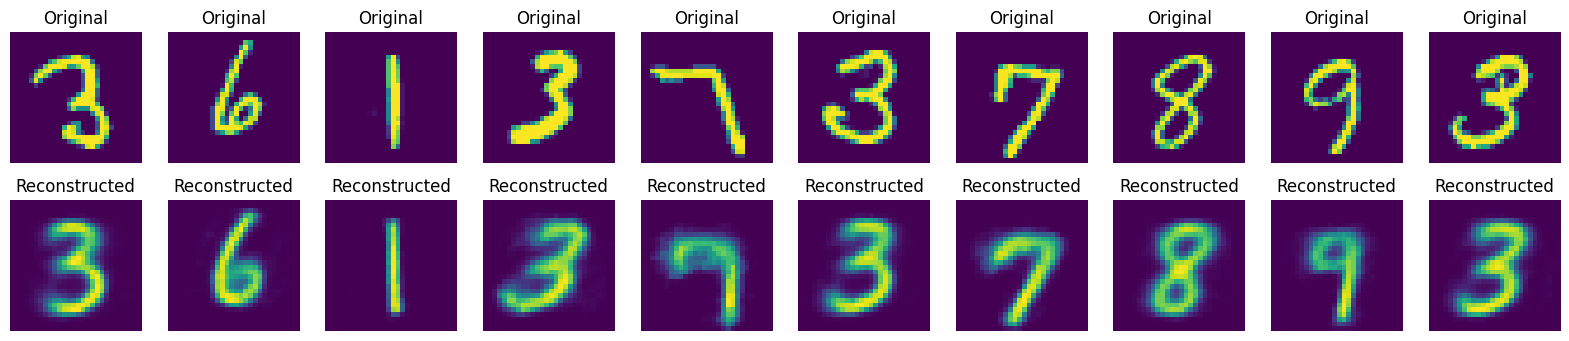

In [11]:
# Plot original and reconstructed images side by side
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image: (C,H,W)-> (H,W,C)
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()